In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [8]:
from buildingspy.io.outputfile import Reader
from scipy.io import loadmat

In [6]:
from pathlib import Path

In [3]:
def time_range(tmin, tmax, t, signal):
    ids = np.where(np.logical_and(t >= tmin, t <= tmax))
    return t[ids], signal[ids]

def read_simulations(path, file_format, data, variables, tmin, tmax):
    for hf_level, subdata in data.items():
        for rpm in subdata:
            file = path + file_format.format(hf_level, rpm)
            reader = Reader(file, 'dymola')
            subdata[rpm] = [
                time_range(tmin, tmax, *reader.values(v)) for v in variables
            ]

In [7]:
folder_standalone_sim = '/media/maousi/Raw/standalone/'
files = list(Path(folder_standalone_sim).iterdir())

In [11]:
data = loadmat(files[0].absolute())
data.keys()

dict_keys(['Aclass', 'name', 'description', 'dataInfo', 'data_1', 'data_2'])

In [23]:
import pandas as pd

In [24]:
path = '/media/maousi/Data/tmp/case_study_pvloop'
files = list(Path(path).iterdir())

In [28]:
df = pd.read_csv(files[0].absolute())
df.head()

,time,AutoregulationCenter.Pcs,ExtraSplanchnicVeins.PC,LeftAtrium.PC,LeftVentricle.V,PulmonaryArteries.PC,PulmonaryArteries.Qout,PulmonaryPeriphericalCirculation.PC,PulmonaryVeins.PC,RightAtrium.PC,...,SplanchnicVeins.Active_fes.Signal,SplanchnicVeins.Inlet.P,SplanchnicVeins.Inlet.Q,SplanchnicVeins.Outlet.P,SystemicArteries.Inlet.P,SystemicArteries.Outlet.P,SystemicArteries.Outlet.Q,TricuspidValve.Inlet.P,TricuspidValve.Inlet.Q,TricuspidValve.Outlet.P
0,0.000000,0.000000,0.000000,0.000000e+00,16.770000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,11.244140,30.142366,-9.114716,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
1,0.000148,0.394017,0.000026,2.134181e-15,16.659663,0.128497,0.054026,4.673249e-07,7.705147e-12,0.003763,...,11.242580,30.140462,-9.113967,0.003763,0.394017,0.000366,-0.195803,0.003763,0.000000,0.128497
2,0.000148,0.394017,0.000026,2.134181e-15,16.659663,0.128497,0.054026,4.673249e-07,7.705147e-12,0.003763,...,11.242580,30.140462,-9.113967,0.003763,0.394017,0.000366,-0.195803,0.003763,0.000000,0.128497
3,0.015000,3.218263,0.006024,3.704962e-06,15.541773,0.765164,27.842465,4.500692e-02,1.052253e-04,0.371624,...,11.225289,29.951565,-9.013123,0.371624,3.218263,0.124373,-43.344276,0.371624,0.000000,0.765164
4,0.030000,4.296307,0.018710,-3.398611e-03,14.479578,0.629186,26.017983,1.152066e-01,5.807532e-04,0.723921,...,11.214725,29.764354,-8.872492,0.723921,4.296307,0.382133,-62.927601,0.723921,37.893962,0.629186


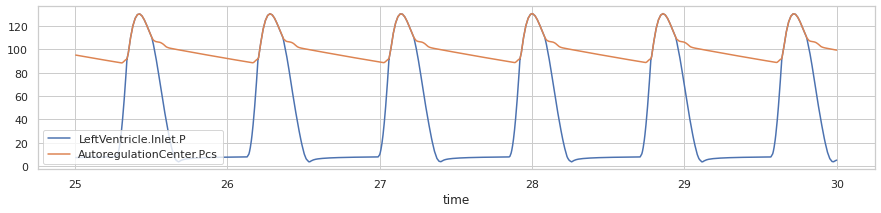

In [43]:
# Plot for sanity check
vars_sanity = ['time', 'LeftVentricle.Inlet.P', 'AutoregulationCenter.Pcs']
df.loc[df.time > 25, vars_sanity].plot(x='time', figsize=(15, 3));

In [44]:
vars_pv = ['time', 'LeftVentricle.Inlet.P', 'LeftVentricle.V']
df_pv = df.loc[df.time > 25, vars_pv]

<AxesSubplot:xlabel='LeftVentricle.V'>

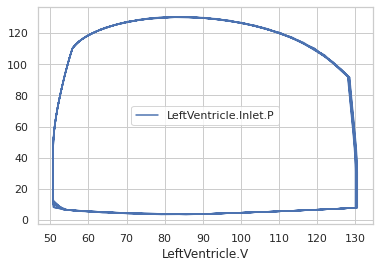

In [51]:
df_pv.plot(y='LeftVentricle.Inlet.P', x='LeftVentricle.V')

In [78]:
peaks, _ = find_peaks(df_pv['LeftVentricle.Inlet.P'], height=100)
peaks

array([ 156,  479,  798, 1116, 1441, 1758])

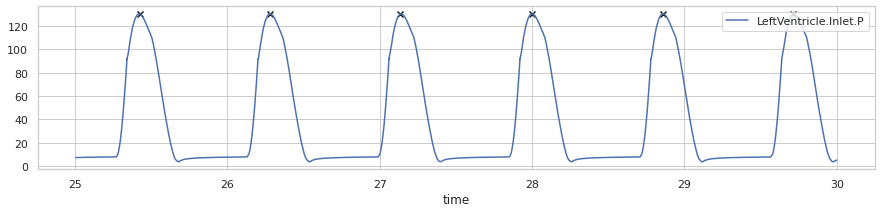

In [83]:
df_pv.plot(x='time', y='LeftVentricle.Inlet.P', figsize=(15, 3))
plt.scatter(df_pv.time.iloc[peaks], df_pv['LeftVentricle.Inlet.P'].iloc[peaks], marker='x', color='k')

In [61]:
df.time[peaks]

149     1.050000
156     1.125000
302     2.385000
472     3.210181
479     3.211253
627     3.669222
792     3.975000
798     4.005000
1109    5.044664
1116    5.046602
1434    6.000000
1441    6.013947
1751    6.863872
1758    6.867411
Name: time, dtype: float64

In [67]:
def load_data(fpath, time_min, columns):
    if 'time' not in columns:
        columns = ['time'] + columns
    df = pd.read_csv(fpath, usecols=columns)
    df = df[df.time >= time_min]
    return df

In [105]:
desc = {e: e.stem.split('_') for e in files}
desc = {k: (v[3], int(v[5]), v[-1]) for k, v in desc.items()}

time_min = 25
vars_pv = ['LeftVentricle.Inlet.P', 'LeftVentricle.V']

data = {
    descriptor_tuple: load_data(file_path, time_min, vars_pv)
    for file_path, descriptor_tuple in desc.items()
    if descriptor_tuple[0] == 'True'
}

In [144]:
from scipy.signal import find_peaks

def detect_volume_peaks(df, var='LeftVentricle.Inlet.P'):
    s = -df[var]
    height = s.mean()
    ids, _ = find_peaks(s, distance=10, height=height)
    return ids

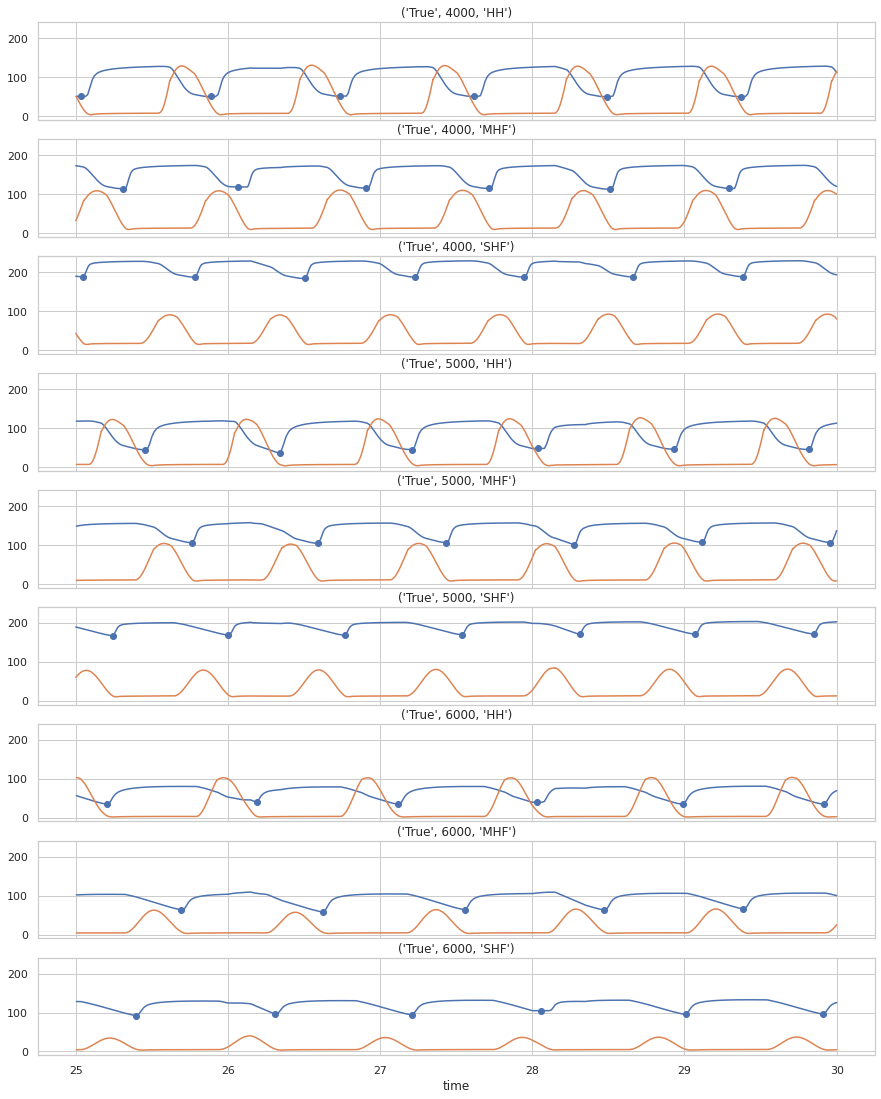

In [166]:
fig, ax = plt.subplots(len(data), 1, figsize=(15, len(data) * 2 + 1), sharex=True, sharey=True)

for (desc, df), a in zip(data.items(), ax):
    y = 'LeftVentricle.V'
    x = 'LeftVentricle.Inlet.P'
    df.plot(x='time', y=y, ax=a, legend=False)
    df.plot(x='time', y=x, ax=a, legend=False)
    peaks = detect_volume_peaks(df, var=y)
    a.scatter(df.time.iloc[peaks], df[y].iloc[peaks])
    a.set_title(desc)

In [244]:
from scipy.spatial import ConvexHull

def plot_pv_loop(df, ax=None, n=1, debug=False, color='b', label=None):
    if ax is None:
        ax = plt.gca()
        
    y = 'LeftVentricle.Inlet.P'
    x = 'LeftVentricle.V'
    height = df[y].max() * 0.8
    peaks = detect_volume_peaks(df, var=x, min_height=height)
    # Get last cardiac cycle
    start, end = peaks[-n-1], peaks[-n]
    
    pts = df.iloc[start:end+1][[x, y]].values
    
    if debug:
        ax.plot(pts[:, 0], pts[:, 1], 'ok')
    
    # https://stackoverflow.com/a/36764176/11552622
    hull = ConvexHull(pts)
    for i, simplex in enumerate(hull.simplices):
        label_ = label if i == 0 else None
        ax.plot(pts[simplex, 0], pts[simplex, 1], color=color, label=label_)
    
    #df.iloc[start:end+1].plot(x=x, y=y, legend=False, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')

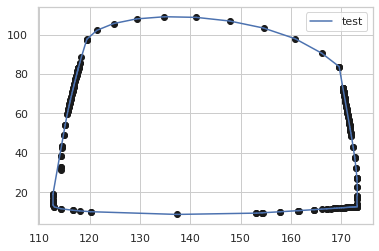

In [245]:
plot_pv_loop(data[('True', 4000, 'MHF')], n=1, debug=True, label='test')
plt.legend();

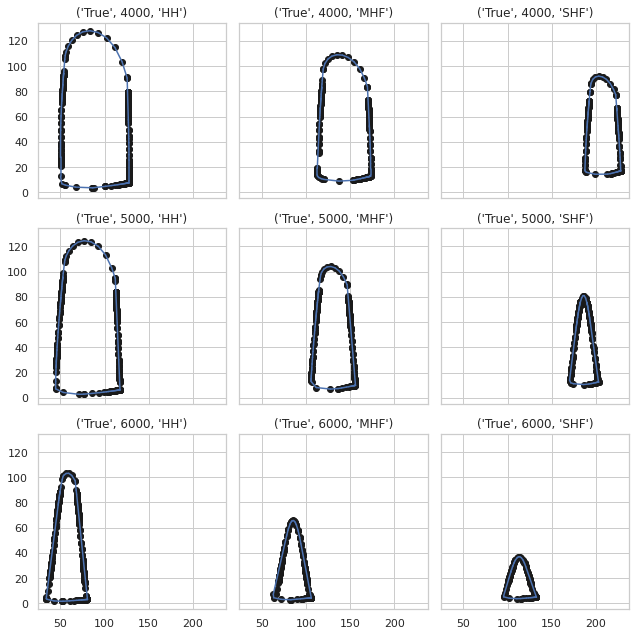

In [246]:
from math import ceil

ncol = 3
nrow = ceil(len(data) / ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(3 * ncol, 3 * nrow), sharex=True, sharey=True)

for (desc, df), a in zip(data.items(), ax.ravel()):
    plot_pv_loop(df, ax=a, debug=True)
    a.set_title(desc)
    
plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


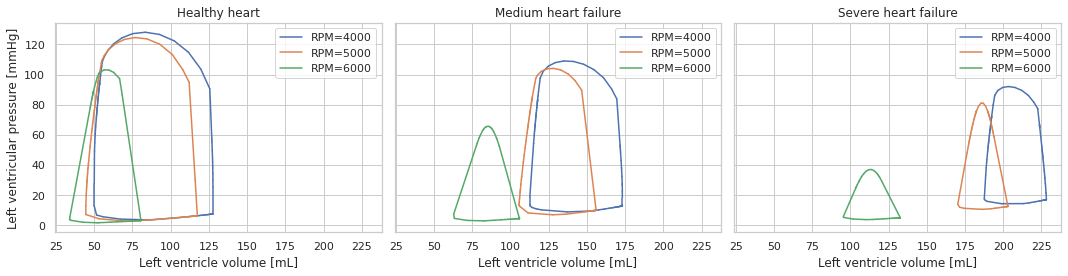

In [239]:
colors = sns.color_palette(n_colors=3)
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

titles = {
    'HH': 'Healthy heart',
    'MHF': 'Medium heart failure',
    'SHF': 'Severe heart failure'
}

for j, hf in enumerate(('HH', 'MHF', 'SHF')):
    for i, rpm in enumerate((4000, 5000, 6000)):
        plot_pv_loop(data[('True', rpm, hf)], ax=ax[j], label=f'RPM={rpm}', color=colors[i])
        ax[j].legend()
    
    ax[j].set_title(titles[hf])
    ax[j].set_xlabel('Left ventricle volume [mL]')
    
ax[0].set_ylabel('Left ventricular pressure [mmHg]')
plt.tight_layout()
plt.savefig('figs/pv_loops.eps', bbox_inches='tight')
plt.savefig('figs/pv_loops.pdf', bbox_inches='tight')

In [237]:
files_nolvad = Path(path).glob('*RPM_0_*.csv')

desc = {e: e.stem.split('_') for e in files_nolvad}
desc = {k: (v[3], int(v[5]), v[-1]) for k, v in desc.items()}

data_nolvad = {
    descriptor_tuple: load_data(file_path, time_min, vars_pv)
    for file_path, descriptor_tuple in desc.items()
}
data_nolvad.keys()

dict_keys([('False', 0, 'HH'), ('False', 0, 'MHF'), ('False', 0, 'SHF')])

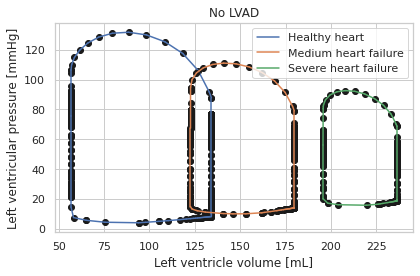

In [264]:
colors = sns.color_palette(n_colors=3)
titles = {
    'HH': 'Healthy heart',
    'MHF': 'Medium heart failure',
    'SHF': 'Severe heart failure'
}

for j, hf in enumerate(('HH', 'MHF', 'SHF')):
    plot_pv_loop(data_nolvad[('False', 0, hf)], label=f'{titles[hf]}', color=colors[j], debug=True)

plt.title('No LVAD')
plt.xlabel('Left ventricle volume [mL]')
plt.ylabel('Left ventricular pressure [mmHg]')
plt.tight_layout()
plt.legend();

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

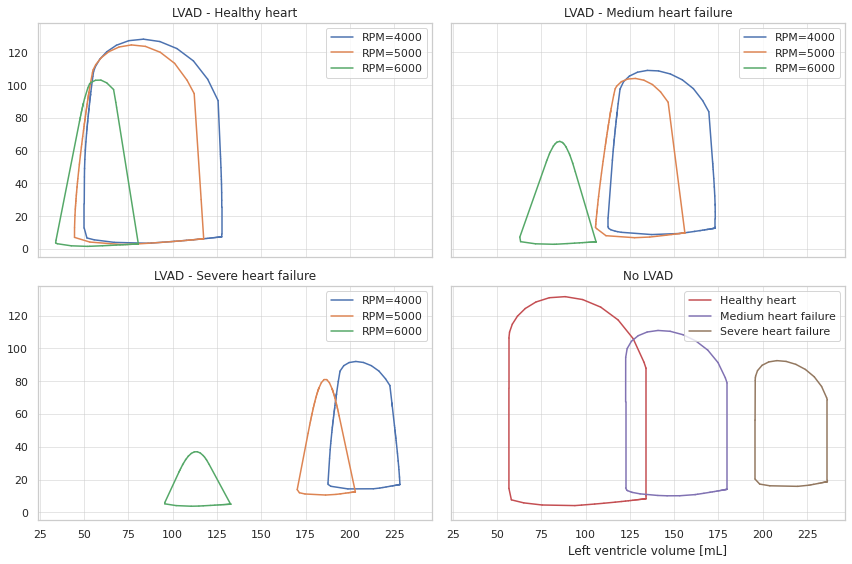

In [263]:
colors = sns.color_palette(n_colors=6)
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
ax = ax.ravel()

# Plot LVAD PV Loops
for j, hf in enumerate(('HH', 'MHF', 'SHF')):
    for i, rpm in enumerate((4000, 5000, 6000)):
        plot_pv_loop(data[('True', rpm, hf)], ax=ax[j], label=f'RPM={rpm}', color=colors[i])
        ax[j].legend()
    
    ax[j].set_title('LVAD - ' + titles[hf])
    #ax[j].set_xlabel('Left ventricle volume [mL]')
    
# Plot without LVAD
a = ax[-1]
for j, hf in enumerate(('HH', 'MHF', 'SHF')):
    plot_pv_loop(data_nolvad[('False', 0, hf)], label=f'{titles[hf]}', color=colors[j + 3], ax=a)
    a.legend()
    
a.set_title('No LVAD')
a.set_xlabel('Left ventricle volume [mL]')

for a in ax:
    a.grid(True, alpha=.5)

plt.tight_layout()
plt.savefig('figs/pv_loops_all.eps', bbox_inches='tight')
plt.savefig('figs/pv_loops_all.pdf', bbox_inches='tight')

In [259]:
!nautilus .